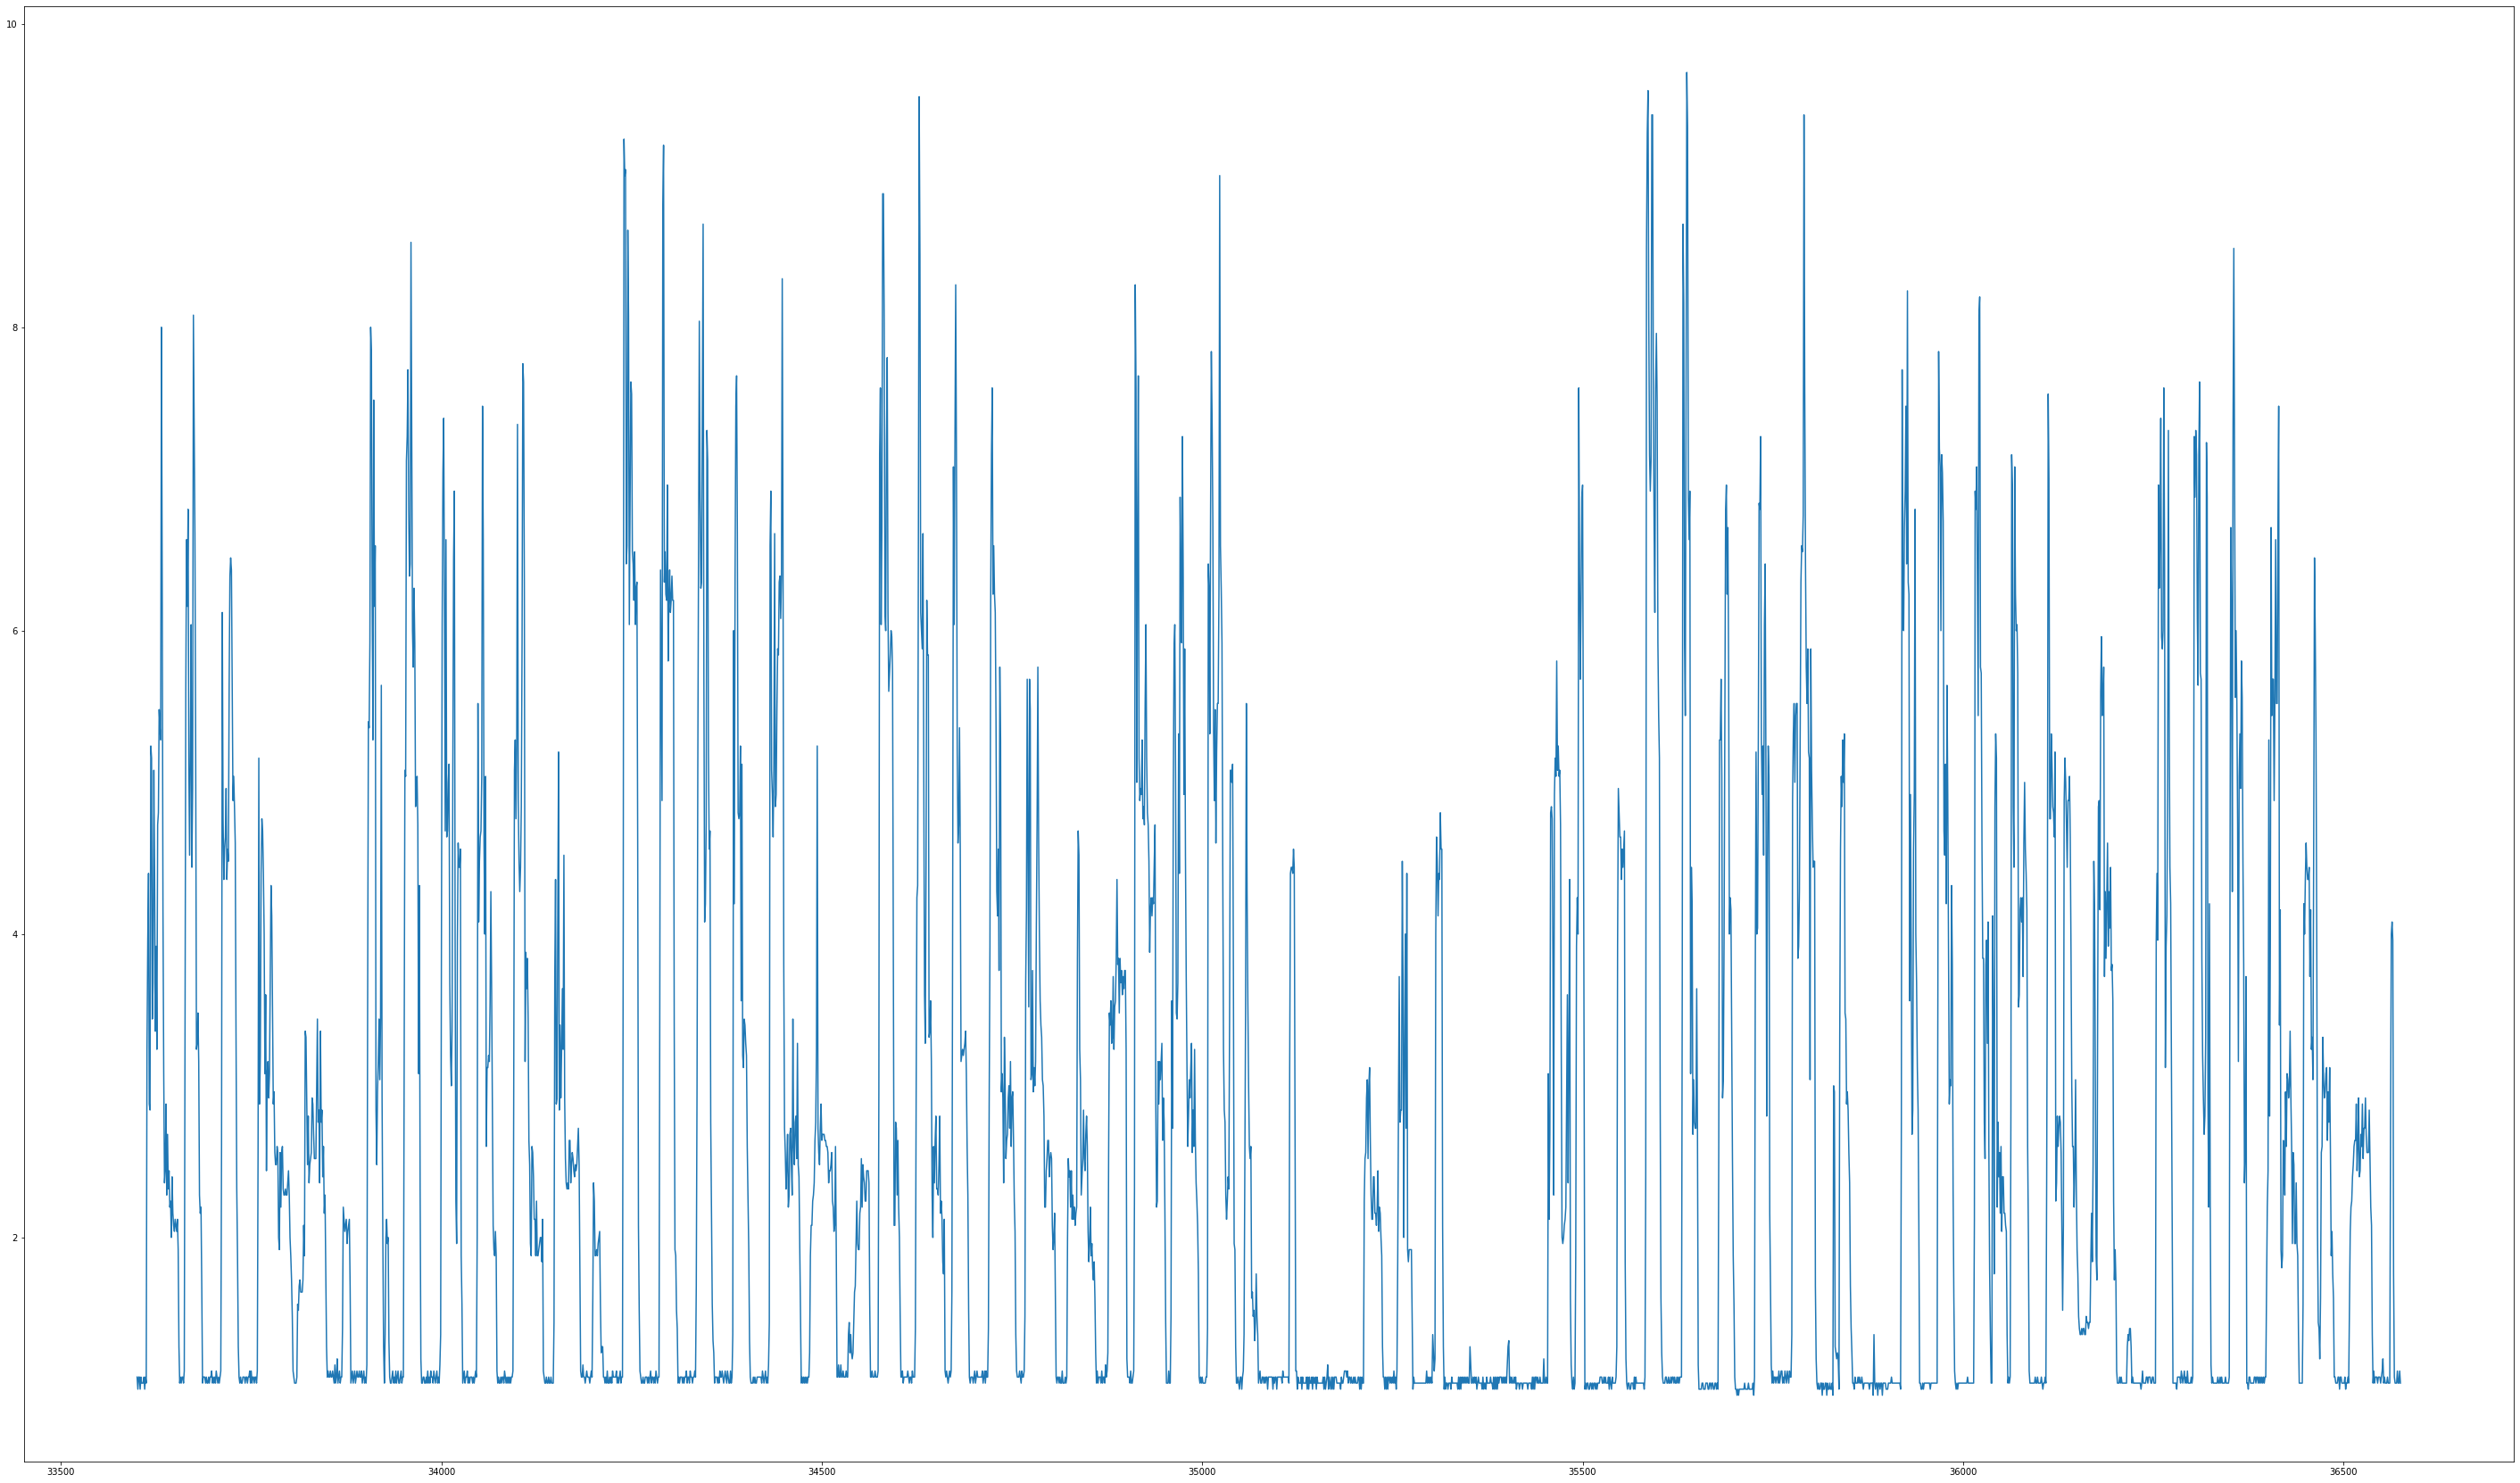

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("office.csv")
plt.figure(figsize=(50, 30))
plt.plot([i for i in range(len(df))[-48*31*2:]], df["value"][-48*31*2:])
data = df.iloc[:, 2].values

In [50]:
# параметры 
s_day =  48 # период сезонности
s_week = 48*7

d = 48*7
idx_start = -31 * 48
idx_start_reg = -31*d*2
idx_end = -d

def MSAE(real, pred):
    return np.power(real-pred, 2).mean()


def MAE(real, pred):
    return abs(real-pred).mean()


def MRE(predicted, real):
    return abs(real - predicted).sum()/(real.sum())

def error_vec(predicted, real):
    return np.abs(real - predicted)/real

In [52]:
# параметры 
s_day =  48 # период сезонности
s_week = 48*7
idx_start = -48*31
d = 48*7
idx_start_reg = -31*d
idx_end = -d

0.5979495704016267
0.5942532514895134
0.5906776021159847


<AxesSubplot:>

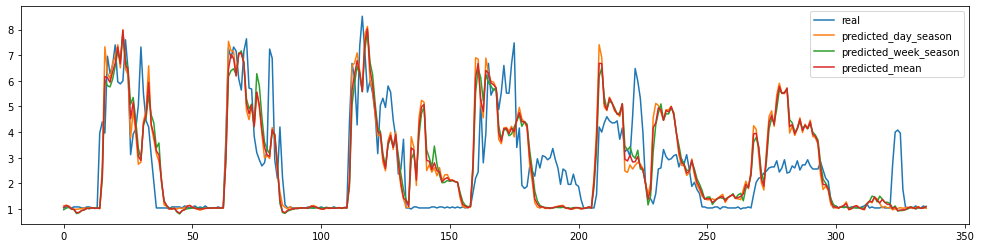

In [21]:
def lin_trend_with_add_season(y, alpha, s, d):  # slide 14
    n = y.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] - theta[t - s]) + (1 - alpha[0]) * (a[t - 1] + b[t - 1])
        b[t] = alpha[1] * (a[t] - a[t - 1])+(1 - alpha[1]) * b[t - 1]
        theta[t] = alpha[2] * (y[t] - a[t]) + (1 - alpha[2]) * theta[t - s]
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = (a[t - d]+(b[t - d] * d)) + theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def lin_trend_with_add_season_fit(series, s, d=48):
    min_error = 1000000
    error_v = np.zeros(d)
    t_a = 0
    t_b = 0
    t_g = 0
    for alpha in range(10):
        for beta in range(10):
            for gamma in range(10):
                train = series[:-d]
                test = series[-d:]
                predicted_next_values = lin_trend_with_add_season(train, np.array([alpha/10, beta/10, gamma/10]), s, len(test))
                e = error_vec(predicted_next_values, np.array(test))
                if e.mean() < min_error:
                    min_error = e.mean()
                    error_v = e
                    t_a = alpha/10
                    t_b = beta/10
                    t_g = gamma/10
    return np.array([t_a, t_b, t_g]), error_v


alpha_day, day_test_error = lin_trend_with_add_season_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day = lin_trend_with_add_season(data[idx_start:idx_end], alpha_day, s_day,  d)

alpha_week, week_test_error = lin_trend_with_add_season_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week = lin_trend_with_add_season(data[idx_start:idx_end], alpha_week, s_week,  d)

real_next_values = np.array(data[idx_end:])

predicted_weight_mean = predicted_next_values_week * (week_test_error / (week_test_error + day_test_error)) + predicted_next_values_day * (day_test_error / (week_test_error + day_test_error))
results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": predicted_next_values_day,
        "predicted_week_season": predicted_next_values_week,
        "predicted_mean": predicted_weight_mean
    }
)
print(MRE(predicted_next_values_day-1, real_next_values-1))
print(MRE(predicted_next_values_week-1, real_next_values-1))
print(MRE(predicted_weight_mean-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))

0.5796307209611515
0.6048787093054079
0.5826312630040462


<AxesSubplot:>

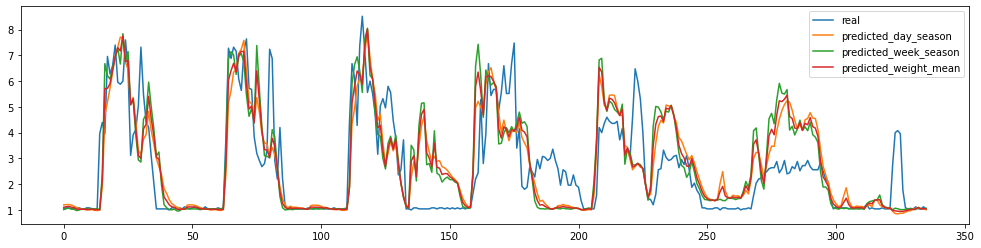

In [22]:
def whinters(y,  alpha, s, d): # d - горизонт прогнозирования  slide 15
    n = y.shape[0]
    
    a = np.zeros(n)
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * a[t - 1]
        theta[t] = alpha[1] * (y[t] / a[t]) + (1 - alpha[1]) * theta[t - s]
    
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = a[t - d] * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])



def whinters_fit(series, s, d=48):
    min_error = 100000
    error_v = np.zeros(d)
    t_a = 0
    t_b = 0
    for alpha in range(10):
        for beta in range(10):
#             for i in range(1, n+1):
#                 train = series[:i*(len(series)//(n+1))]
#                 test = series[i*(len(series)//(n+1)):(i+1)*(len(series)//(n+1))]
#                 predicted_next_values = predict(train, np.array([alpha/10, beta/10]), len(test))
#                 errors.append(error(predicted_next_values, test))
#             print(np.array(errors))
            train = series[:-d]
            test = series[-d:]
            predicted_next_values = whinters(train, np.array([alpha/10, beta/10]), s, len(test))
            e = error_vec(predicted_next_values, np.array(test))
            if e.mean() < min_error:
                min_error = e.mean()
                error_v = e
                t_a = alpha/10
                t_b = beta/10
    return np.array([t_a, t_b]), min_error

alpha_day, day_test_error = whinters_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day = whinters(data[idx_start:idx_end], alpha_day, s_day,  d)

alpha_week, week_test_error = whinters_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week = whinters(data[idx_start:idx_end], alpha_week, s_week,  d)
real_next_values = np.array(data[idx_end:])

predicted_weight_mean = predicted_next_values_week * (week_test_error / (week_test_error + day_test_error)) + predicted_next_values_day * (day_test_error / (week_test_error + day_test_error))
results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": predicted_next_values_day,
        "predicted_week_season": predicted_next_values_week,
        "predicted_weight_mean": predicted_weight_mean
    }
)
print(MRE(predicted_next_values_day-1, real_next_values-1))
print(MRE(predicted_next_values_week-1, real_next_values-1))
print(MRE(predicted_weight_mean-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))

0.6047304812041225
0.6047304812041225


<AxesSubplot:>

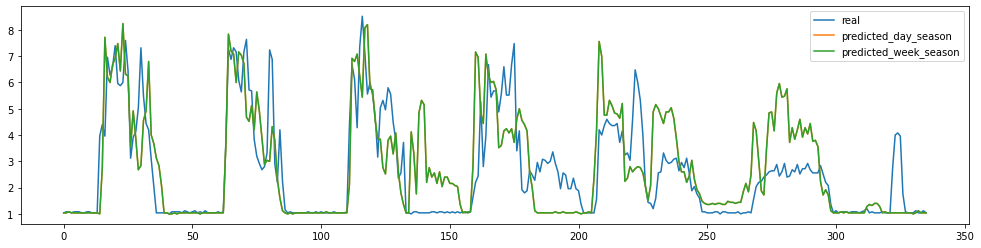

In [23]:
def trigg_lych(y, alpha, s, d, gamma=0.05):
    n = y.shape[0]
    a = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    error_v = np.zeros(d)
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * a[t - 1]
        theta[t] = alpha[1] * (y[t] / a[t]) + (1 - alpha[1]) * theta[t - s]
        e[t] = gamma*(a[t] * theta[t + (d % s) - s]-y[t])+(1-gamma)*(e[t-1])
        e_abs[t] = gamma*(a[t] * theta[t + (d % s) - s]-y[t])+(1-gamma)*(e_abs[t-1])
        if n-d <= t < n:
            error_v[t-n+d] = abs(a[t - d] * theta[t - d + (d % s) - s] - y[t])
        if not np.isclose(e_abs[t], 0):
            K = abs(e[t]/e_abs[t])
            alpha[0] = K
        
        
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = a[t - d] * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:]), error_v


predicted_next_values_day, _ = trigg_lych(data[idx_start:idx_end], alpha_day, s_day,  d)

predicted_next_values_week, _ = trigg_lych(data[idx_start:idx_end], alpha_week, s_week,  d)

real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": predicted_next_values_day,
        "predicted_week_season": predicted_next_values_week
    }
)
print(MRE(predicted_next_values_day-1, real_next_values-1))
print(MRE(predicted_next_values_week-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))


0.5885272989594303
0.6048787093054079
0.5842485370255001


<AxesSubplot:>

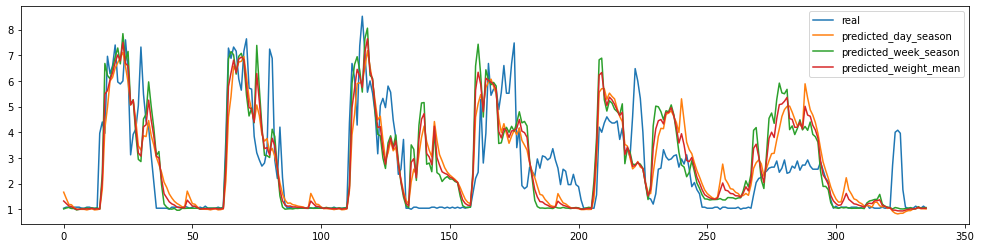

In [24]:
def whinters_with_linear_trend(y, alpha, s, d):  # slide 16
    n = y.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * (a[t - 1] + b[t - 1])
        b[t] = alpha[1] * (a[t] - a[t - 1])+(1 - alpha[1]) * b[t - 1]
        theta[t] = alpha[2] * (y[t] / a[t]) + (1 - alpha[2]) * theta[t - s]
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = (a[t - d]+(b[t - d] * d)) * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def whinters_with_linear_trend_fit(series, s,  d=48):
    min_error = 4
    t_a = 0
    t_b = 0
    t_g = 0
    for alpha in range(10):
        for beta in range(10):
            for gamma in range(10):
                train = series[:-d]
                test = series[-d:]
                predicted_next_values = whinters_with_linear_trend(train, np.array([alpha/10, beta/10, gamma/10]), s, len(test))
                e = MRE(predicted_next_values, np.array(test))
                if e < min_error:
                    min_error = e
                    t_a = alpha/10
                    t_b = beta/10
                    t_g = gamma/10
    return np.array([t_a, t_b, t_g]), min_error


alpha_day, day_test_error = whinters_with_linear_trend_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day = whinters_with_linear_trend(data[idx_start:idx_end], alpha_day, s_day,  d)

alpha_week, week_test_error = whinters_with_linear_trend_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week = whinters_with_linear_trend(data[idx_start:idx_end], alpha_week, s_week,  d)
real_next_values = np.array(data[idx_end:])

predicted_weight_mean = predicted_next_values_week * (week_test_error / (week_test_error + day_test_error)) + predicted_next_values_day * (day_test_error / (week_test_error + day_test_error))
results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": predicted_next_values_day,
        "predicted_week_season": predicted_next_values_week,
        "predicted_weight_mean": predicted_weight_mean
    }
)
print(MRE(predicted_next_values_day-1, real_next_values-1))
print(MRE(predicted_next_values_week-1, real_next_values-1))
print(MRE(predicted_weight_mean-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))

c:\users\valery\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


0.5796307209611515
0.6048787093054079
0.5823522818702163


<AxesSubplot:>

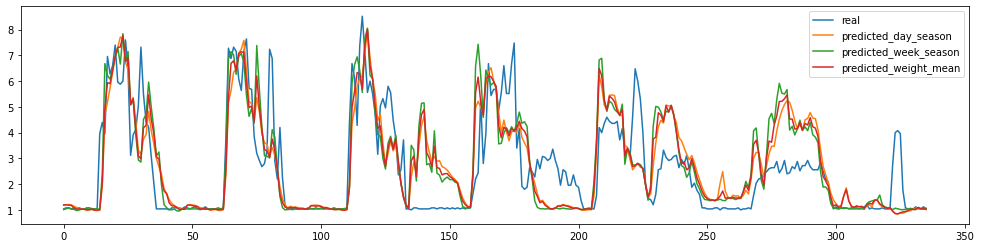

In [25]:
def whinters_with_exp_trend(y, alpha, s, d):    #  slide 17
    n = y.shape[0]
    a = np.zeros(n)
    r = np.ones(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * (a[t - 1] * r[t - 1])
        r[t] = alpha[1] * (a[t] / a[t - 1] ) + (1 - alpha[1])*r[t - 1]
        theta[t] = alpha[2] * (y[t] / a[t]) + (1 - alpha[2]) * theta[t - s]
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = (a[t - d] * (r[t - d]) ** d) * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def whinters_with_exp_trend_fit(series, s, d=48):
    min_error = 10000
    error_v = np.zeros(d)
    t_a = 0
    t_b = 0
    t_g = 0
    for alpha in range(10):
        for beta in range(10):
            for gamma in range(10):
                train = series[:-d]
                test = series[-d:]
                predicted_next_values = whinters_with_exp_trend(train, np.array([alpha/10, beta/10, gamma/10]), s, len(test))
                e = error_vec(predicted_next_values, np.array(test))
                if e.mean() < min_error:
                    min_error = e.mean()
                    error_v = e
                    t_a = alpha/10
                    t_b = beta/10
                    t_g = gamma/10
    return np.array([t_a, t_b, t_g]), error_v


alpha_day, day_test_error = whinters_with_exp_trend_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day = whinters_with_exp_trend(data[idx_start:idx_end], alpha_day, s_day,  d)

alpha_week, week_test_error = whinters_with_exp_trend_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week = whinters_with_exp_trend(data[idx_start:idx_end], alpha_week, s_week,  d)
real_next_values = np.array(data[idx_end:])

predicted_weight_mean = predicted_next_values_week * (week_test_error / (week_test_error + day_test_error)) + predicted_next_values_day * (day_test_error / (week_test_error + day_test_error))
results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": predicted_next_values_day,
        "predicted_week_season": predicted_next_values_week,
        "predicted_weight_mean": predicted_weight_mean
    }
)
print(MRE(predicted_next_values_day-1, real_next_values-1))
print(MRE(predicted_next_values_week-1, real_next_values-1))
print(MRE(predicted_weight_mean-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))

1.1152657467795697


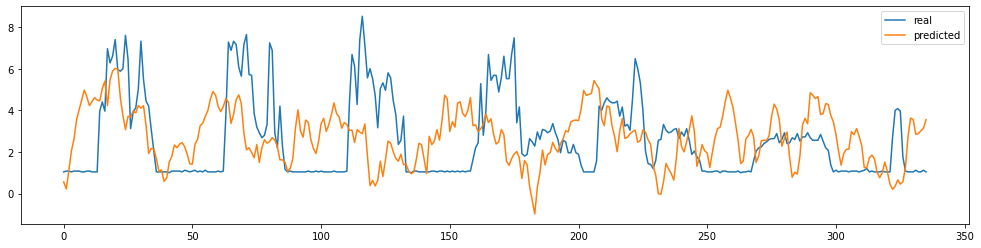

In [40]:
def auto_regression(y, alpha, d): # d - горизонт прогнозирования
    n = y.shape[0]

    k = d
    w = np.random.random(k)
    eps = np.zeros(n)
    h = np.zeros(n)
    error_v = np.zeros(k)
    y_predicted = np.concatenate((y, np.zeros(d)))
    
    for t in range(k, n):
        y_predicted[t] = sum(w[j] * y_predicted[t - j - 1] for j in range(k))
        h[t] = alpha / sum(y_predicted[t - j - 1]**2 for j in range(k))
        y_ = np.array([y_predicted[t - j - 1] for j in range(k)])
        eps[t] = y[t] - y_predicted[t]
        w += h[t] * eps[t] * y_
        y_predicted[t] = sum(w[j] * y_predicted[t - j - 1] for j in range(k))
        
        if n-k <= t < n:
            error_v[t-n+k] = abs(y[t] - y_predicted[t])
    for t in range(n, n+d):
        y_predicted[t] = sum(w[j] * y_predicted[t - j - 1] for j in range(k))
    
    return np.array(y_predicted[n:]), error_v


alpha = 0.35
predicted_next_values, _ = auto_regression(data[idx_start_reg:idx_end], alpha, d)
real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": predicted_next_values
    }
)

results_predict.plot(figsize=(17, 4))
print(MRE(predicted_next_values-1, real_next_values-1))

0.5765250426652431


<AxesSubplot:>

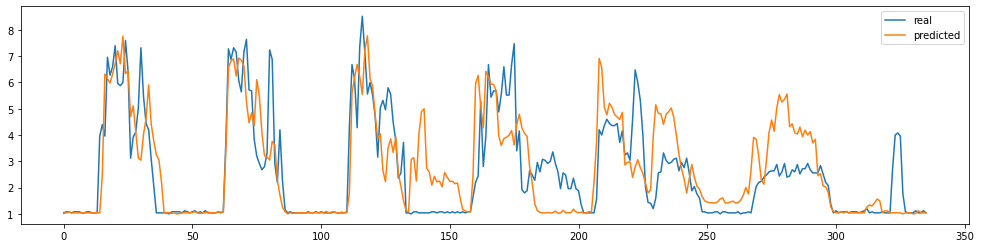

In [53]:
real_next_values = np.array(data[idx_end:])
n_models = 9
errors = np.ndarray(shape=(n_models, d), dtype=float)
preds = np.ndarray(shape=(n_models, d), dtype=float)

alpha_day_1, day_test_error_1 = lin_trend_with_add_season_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day_1 = lin_trend_with_add_season(data[idx_start:idx_end], alpha_day_1, s_day,  d)
errors[0] = day_test_error_1
preds[0] = predicted_next_values_day_1

alpha_week_1, week_test_error_1 = lin_trend_with_add_season_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week_1 = lin_trend_with_add_season(data[idx_start:idx_end], alpha_week_1, s_week,  d)
errors[1] = week_test_error_1
preds[1] =predicted_next_values_week_1


alpha_day_2, day_test_error_2 = whinters_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day_2 = whinters(data[idx_start:idx_end], alpha_day_2, s_day,  d)
errors[2] = day_test_error_2
preds[2] = predicted_next_values_day_2

alpha_week_2, week_test_error_2 = whinters_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week_2 = whinters(data[idx_start:idx_end], alpha_week_2, s_week,  d)
errors[3] = week_test_error_2
preds[3] = predicted_next_values_week_2


alpha_day_3, day_test_error_3 = whinters_with_linear_trend_fit(data[idx_start:idx_end], s_day, d)
predicted_next_values_day_3 = whinters_with_linear_trend(data[idx_start:idx_end], alpha_day_3, s_day,  d)
errors[4] = day_test_error_3
preds[4] = predicted_next_values_day_3

alpha_week_3, week_test_error_3 = whinters_with_linear_trend_fit(data[idx_start:idx_end], s_week, d)
predicted_next_values_week_3 = whinters_with_linear_trend(data[idx_start:idx_end], alpha_week_3, s_week,  d)
errors[5] = week_test_error_3
preds[5] = predicted_next_values_week_3

alpha_reg = 0.35
predicted_next_values_regression, error_test_regression = auto_regression(data[idx_start_reg:idx_end], alpha_reg, d)
errors[6] = error_test_regression
preds[6] = predicted_next_values_regression


predicted_next_values_day_trigg, error_trigg_day = trigg_lych(data[idx_start:idx_end], alpha_day, s_day,  d)
errors[7] = error_trigg_day
preds[7] = predicted_next_values_day_trigg

predicted_next_values_week_trigg, error_trigg_week = trigg_lych(data[idx_start:idx_end], alpha_week, s_week,  d)
errors[8] = error_trigg_week
preds[8] = predicted_next_values_week_trigg



errors = np.array(errors)
preds = np.array(preds)
errors = np.where(np.isclose(errors, 0), 0.0001, errors)
weights = (1/errors)/(1/errors).sum(axis=0).reshape(1, -1)
weights[weights < 0] = 0
pred_final = (preds*weights).sum(axis=0)
pred_final[pred_final < 1] = 1

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": pred_final
    }
)

print(MRE(pred_final-1, real_next_values-1))
results_predict.plot(figsize=(17, 4))

In [27]:
idx_start = -48*31*4
idx_end = -48*14
s_week = 48*7
d = -idx_end
def MAE(real, pred):
    return abs(real-pred).mean()


def MRE(predicted, real):
    return abs(real - predicted).sum()/(real.sum())

0.31309321663426
0.06620666239543165


<AxesSubplot:>

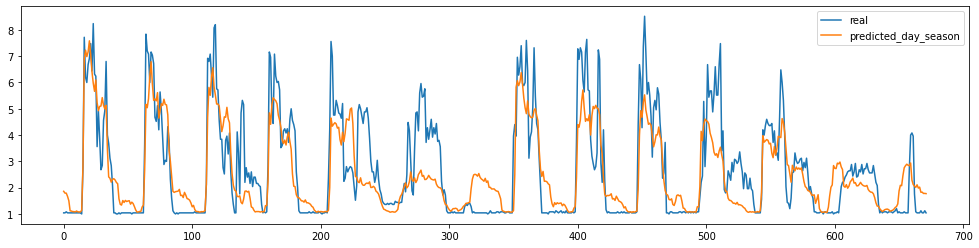

In [28]:
from scipy.optimize import minimize
class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train, alpha):
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = train.min()
        
        for t in range(self.s):
            self.theta[t] = train[t]
            self.a[t] = train[t]
        
        for t in range(self.s, self.n):
            self.a[t] = alpha[0] * (train[t] / self.theta[t - self.s]) + (1 - alpha[0]) * self.a[t - 1]
            self.theta[t] = alpha[1] * (train[t] / self.a[t]) + (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d=1):
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted
    
def optimize_alpha(alpha, s, train_data, real_data, d):
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    
    return MAE(real_data, winters_model.predict(d)) # your error function
 
result = minimize(
    lambda x: optimize_alpha(x, s_week, data[idx_start:2*idx_end], data[2*idx_end:idx_end:], d),
    x0=np.array([0.5, 0.5]),
    bounds=[(0, 1), (0, 1)]
)
alpha_optimized = result.x
winters_model = WintersNoTrend(s_week)
winters_model.fit(data[idx_start:idx_end], alpha_optimized)
                  
pred = winters_model.predict(d)
real_next_values = data[idx_end:]

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": pred

    }
)


print(MRE(pred, real_next_values))
print(abs(pred.sum() - real_next_values.sum())/(real_next_values.sum()))
results_predict.plot(figsize=(17, 4))